# **Computer Vision Workshop** - CIFAR10 Classification - PART II

![alt](https://kibernetika.ai/wp-content/uploads/2018/11/CIFAR-10.png)

## <ins>Pre VII. Introduction</ins>

Welcome to this Google Colaboratory (Colab) Jupyter Notebook, where you will learn how to leverage the powerful TensorFlow library for image classification on the CIFAR-10 dataset. This is an interactive learning experience where you'll build and progressively improve a deep learning model, step by step.

This is the **2/2 notebook**, it has been split into two contiguous notebooks for the sake of readability.

The primary objective of this notebook is to serve as a guide, providing you with a comprehensive example to follow. As this is the initial notebook you'll be navigating through, it's designed to illustrate the process in detail.

**Feel free to modify and experiment with the given code !**

There also are

<details open>
  <summary><h3>🔎 <ins>To Go Further<ins/><h3/></summary>

  > sections which can give you an idea of what you could try, with the difficulity in ⭐
  I strongly advise you to try following them !
</details>

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The classes include objects such as cars, birds, cats, dogs, and more.

**I hope you like it 😀 and that it gives you the necessary tools to compete in the Kaggle contest !**

Let's get started !

If you have any questions regarding this notebook, add me on Discord : **OrdinaryDev83#9338**

## Previous Code
Run this cell to import all the previous notebook's code.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils, applications
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

tf.random.set_seed(42)
np.random.seed(42)
ds_dict, ds_info = tfds.load('cifar10', as_supervised=False, with_info=True)
class_names = ds_info.features['label'].names
n_classes = len(class_names)
ds_train, ds_test = ds_dict["train"], ds_dict["test"]
nb_examples_test = ds_info.splits["test"].num_examples
nb_examples_validation = int(nb_examples_test * 0.1)
ds_validation = ds_test.take(nb_examples_validation)
ds_test = ds_test.skip(nb_examples_validation)

def shape(x):
  """
  Extracts the dictionary into a tuple X, Y
  """
  return x['image'], x['label']

img_size = 32

def preprocess(img, label):
    img = tf.cast(img, dtype=tf.float32)
    return img, tf.one_hot(int(label), n_classes)

batch_size = 256

def preprocess_dataset(ds):
    ds = ds.map(shape, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(len(ds))
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(1)
    return ds

ds_train = preprocess_dataset(ds_train)
ds_validation = preprocess_dataset(ds_validation)
ds_test = preprocess_dataset(ds_test)

def normalize(img, label):
  img = tf.cast(img / 255.0, dtype=tf.float32)
  return img, label

ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

def plot_history(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.tight_layout()
  plt.show()

def plot_model_architecture(model):
  tf.keras.utils.plot_model(
    model,
    to_file="my_model.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True
  )
  display(Image(filename='my_model.png'))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteGHV1P4/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteGHV1P4/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## VII. <ins>Enhancing the model with data augmentation and dropout</ins>

### A. Introduction to data augmentation techniques
Data augmentation is a strategy that enables us to significantly increase the diversity of data available for training models, without actually collecting new data. It works by applying random transformations to the existing training data, such as rotations, scaling, translations, flips, and more. The result is that the model can learn from slightly altered versions of the same image, which can help it generalize better to unseen data.

> ![h](https://albumentations.ai/docs/images/introduction/image_augmentation/augmentation.jpg)

### B. Implementing data augmentation

The given code block creates a `Sequential` model for data augmentation, using three types of augmentation:

1. `RandomRotation(18/360)`: This layer applies a random rotation to each image. The rotation angle will be a random value in the range `-18° to 18°`. This can help the model learn to recognize the same object at different orientations.

2. `RandomZoom(0.2)`: This layer applies a random zoom to each image. The zoom factor will be a random value in the range `1-0.2 to 1+0.2`. This can help the model learn to recognize the same object at different scales.

3. `RandomFlip(mode="horizontal")`: This layer applies a random horizontal flip to each image. This means that an image can be flipped along the vertical axis, like looking at the image in a mirror. This can help the model learn to recognize the same object even when its orientation is flipped.

In [2]:
# Implementing data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(18/360, input_shape=(img_size, img_size, 3)),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomFlip(mode="horizontal")
])

<details>
  <summary><h3>🔎 <ins>To Go Further<ins/><h3/></summary>

  1. **⭐Adjust the current layers parameters**: Experiment with different parameters values in the preprocessing layers. Determine the range of values that produces the best performance and diversity in the augmented data.

  2. **⭐⭐Explore additional data augmentation techniques**: Research and implement other data augmentation techniques available in TensorFlow's `tf.keras.layers.Random*` module (https://www.tensorflow.org/s/results?q=layer%20Random). Consider techniques like shear, translation, brightness adjustment, or color augmentation. Combine multiple augmentation layers and observe the impact on the model's performance and generalization.
  <blockquote>
  Be careful of pixel range (0.0 -> 1.0 here), some layers might modify it.
  <blockquote/>
</details>

Normal Batch


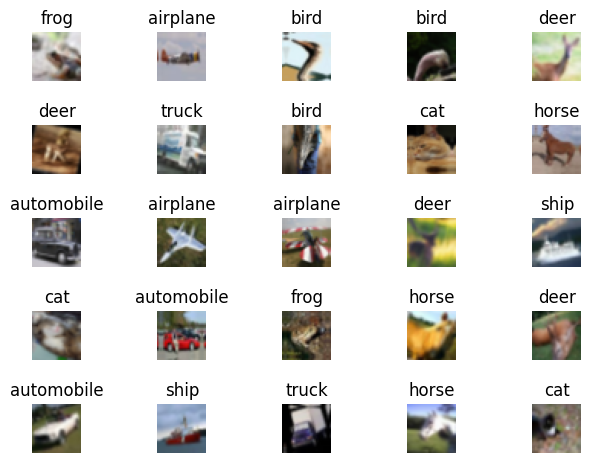

Augmented Batch


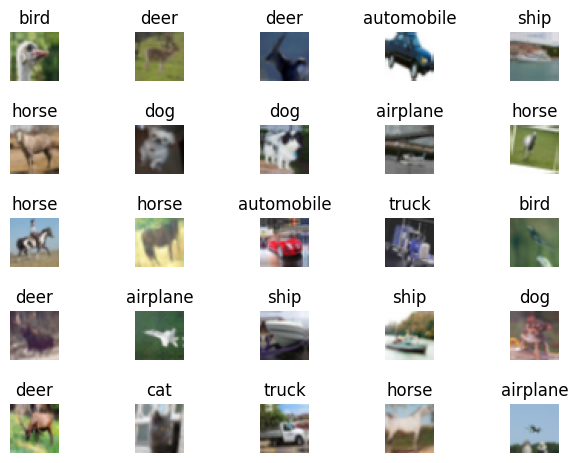

In [3]:
def visualize_examples(augmentation_model):
  one_batch = ds_train.take(1)
  grid_size = 5
  fig, axs = plt.subplots(grid_size, grid_size)
  fig.tight_layout()

  for images, labels in one_batch:
    for i, data in enumerate(zip(data_augmentation(images), labels)):
      if i >= grid_size * grid_size:
        break
      image, label = data
      axs[i // grid_size, i % grid_size].imshow(image, cmap="gray")
      axs[i // grid_size, i % grid_size].set_title(class_names[np.argmax(label)])
      axs[i // grid_size, i % grid_size].set_axis_off()
    break
  plt.show()

print("Normal Batch")
visualize_examples(lambda x: x)
print("Augmented Batch")
visualize_examples(data_augmentation)

### C. Adding Dropout layers

Dropout is a regularization technique for reducing overfitting in neural networks. The technique temporarily drops out, or "turns off", a random set of neurons in a layer during training, which helps to prevent overfitting by making the network more robust and less dependent on the training data.

In this updated model architecture, two dropout layers are added with a rate of 0.2:

 - `layers.Dropout(0.2)`: These lines add a dropout layer. During training, it will randomly set 20% of the input units to 0 at each update, helping to prevent overfitting.
 > ![g](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif)

These dropout layers act as a form of regularization, helping to prevent the model from overfitting to the training data. By randomly "dropping out" a fraction of the neurons, they force the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons. **You shouldn't use dropouts directly after convolutions**.

The remaining parts of the code define the architecture of the model and compile it. The model is now a convolutional neural network with data augmentation and dropout, which should help it generalize better to unseen data.

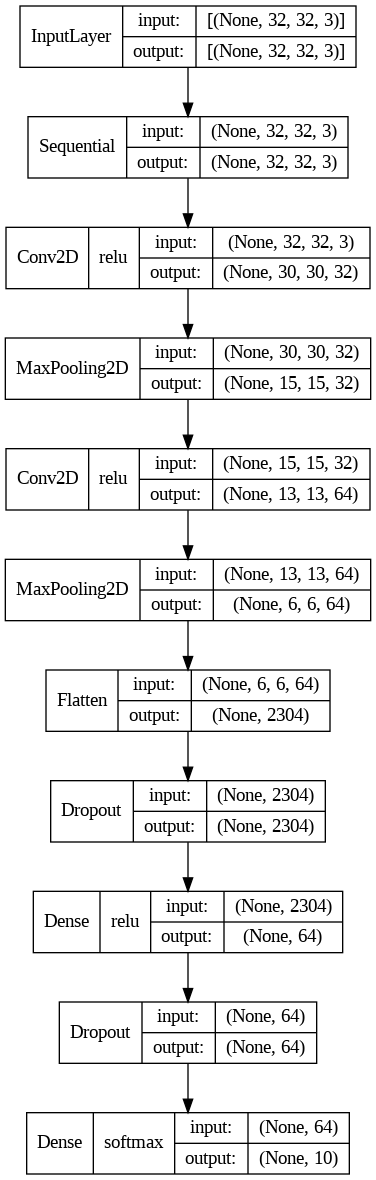

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)             

In [4]:
# Enhancing the model with data augmentation
cnn_model_aug = models.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(n_classes, activation='softmax')
])

plot_model_architecture(cnn_model_aug)

cnn_model_aug.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
cnn_model_aug.summary()

<details>
  <summary><h3>🔎 <ins>To Go Further<ins/><h3/></summary>
  
  1. **⭐Adjust the dropout rate**: Modify the dropout rate in the `Dropout` layers. Experiment with different dropout rates, such as 0.1 or 0.3, and evaluate their effect on preventing overfitting. Higher dropout rates may increase regularization but can also reduce the model's capacity to learn.

  > Don't stack a Dropout layer right after a Conv2D layer ! (don't be that type of person) (https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2)

</details>

### D. Retraining the model with augmented data and dropout


Let's re-train the model with the changes, while extending the training process.

In [5]:
history = cnn_model_aug.fit(ds_train, epochs=10, validation_data=ds_validation)

Epoch 1/10
196/196 [==============================] - 17s 17ms/step - loss: 1.8157 - accuracy: 0.3342 - val_loss: 1.4300 - val_accuracy: 0.4790
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 1.5194 - accuracy: 0.4531 - val_loss: 1.3260 - val_accuracy: 0.5250
Epoch 3/10
196/196 [==============================] - 2s 10ms/step - loss: 1.4282 - accuracy: 0.4869 - val_loss: 1.3245 - val_accuracy: 0.5330
Epoch 4/10
196/196 [==============================] - 2s 11ms/step - loss: 1.3617 - accuracy: 0.5140 - val_loss: 1.2819 - val_accuracy: 0.5470
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 1.3109 - accuracy: 0.5314 - val_loss: 1.1669 - val_accuracy: 0.5910
Epoch 6/10
196/196 [==============================] - 3s 14ms/step - loss: 1.2688 - accuracy: 0.5501 - val_loss: 1.1525 - val_accuracy: 0.6040
Epoch 7/10
196/196 [==============================] - 2s 11ms/step - loss: 1.2381 - accuracy: 0.5618 - val_loss: 1.1116 - val_accuracy: 0.610

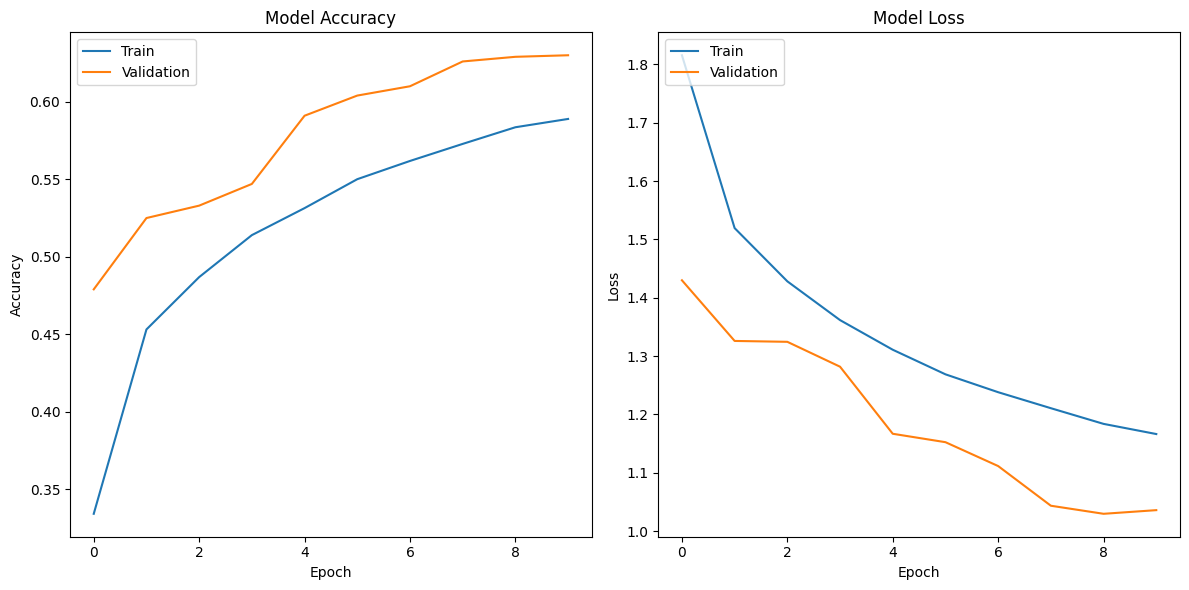

In [6]:
plot_history(history)

Success ! We greatly reduced overfitting.

### E. Evaluating the model


In [7]:
test_loss, test_acc = cnn_model_aug.evaluate(ds_test, verbose=2)
print('\nTest accuracy:', round(test_acc, 4))

36/36 - 1s - loss: 1.0824 - accuracy: 0.6262 - 1s/epoch - 42ms/step

Test accuracy: 0.6262


## VIII. <ins>Exploring transfer learning & fine-tuning</ins>

Transfer learning is a technique where a pre-trained model is used as the starting point for a new, related task. This is particularly useful when you have limited training data, because the pre-trained model has already learned a robust set of features from a larger dataset, which can be reused for the new task.

In this case, the code is using a pre-trained DenseNet121 model. DenseNet121 is a model that has been pre-trained on the ImageNet dataset, a large dataset of 1.2 million images and 1000 classes. By using this pre-trained model, we can leverage the features that the DenseNet121 model has already learned from its extensive training.

> ![h](https://i.imgur.com/dBnpS1v.png)

### A. Selecting and importing a pre-trained model


Here are the steps being performed in this code:

1. `base_model = applications.DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')`: This line loads the pre-trained DenseNet121 model. The `include_top=False` argument means that the final fully-connected layer, which was originally trained for 1000 classes, is not loaded. This allows us to add our own final layer for our specific task.
> ![j](https://pytorch.org/assets/images/densenet1.png)

2. `for i, layer in enumerate(base_model.layers): layer.trainable = i > len(base_model.layers) - 10`: This loop sets the last 10 layers of the base model to be trainable, and the rest to be non-trainable. This is known as "fine-tuning". The idea is that the initial layers of the model have learned general features that are applicable to many tasks, while the later layers have learned more specific features relevant to the specific task the model was originally trained on. By allowing the last few layers to be trainable, we enable them to adjust these specific features to our specific task.

In [8]:
# Transfer learning using a pre-trained model

# the higher the better, but also the slower
# this is why we keep img_size if we can't have access to a GPU
new_img_size = 224 if tf.config.list_physical_devices('GPU') != [] else img_size
print(new_img_size)

base_model = applications.densenet.DenseNet121(input_shape=(new_img_size, new_img_size, 3), include_top=False, weights='imagenet')
for i, layer in enumerate(base_model.layers):
  layer.trainable = i > len(base_model.layers) - 10

224
29084464/29084464 [==============================] - 1s 0us/step


<details>
  <summary><h3>🔎 <ins>To Go Further<ins/><h3/></summary>
  
  1. **⭐⭐⭐Change the pre-trained model**: Explore different pre-trained models available in TensorFlow, such as ResNet, VGG16, or InceptionV3 (https://www.tensorflow.org/api_docs/python/tf/keras/applications). Replace `DenseNet121` with another pre-trained model and observe the impact on the model's performance and ability to learn from the CIFAR-10 dataset. 
    - Be careful, some models require that you add their preprocessing layer in the sequence model, before the pretrained model in the sequence model. It's called `preprocess_input` which is shared across families of models.
      > Example for `tf.keras.applications.efficientnet_v2.preprocess_input`.
        ```python
        ...models.Sequential([
          layers.Input(shape=(img_size, img_size, 3)),
          data_augmentation,
          tf.keras.applications.efficientnet_v2.preprocess_input,
          base_model
          ...
        ])
        ```
    - Some also require a minimum image size.

  2. **⭐Adjust the number of trainable layers**: Experiment with the number of trainable layers in the pre-trained model. Modify the condition `i > len(base_model.layers) - 10` to control which layers that are trainable. Increase or decrease the number of trainable layers and evaluate the effect on the model's performance. Be cautious not to make too many layers trainable, as it may lead to overfitting or an OEM error.

  3. **⭐⭐⭐Fine-tune different layers**: Instead of using a fixed number of trainable layers from the end, selectively fine-tune specific layers in the pre-trained model. Choose different layers and mark them as trainable. Observe the impact of fine-tuning these specific layers on the model's ability to learn and generalize. (You will need to read documentation about the model's architecture)
</details>

### B. Adapting the pre-trained model for the CIFAR10 dataset


We use the `Sequential` model to stack everything up, notice the data augmentation sequence has been added inside the final model. We also added a resize layer.

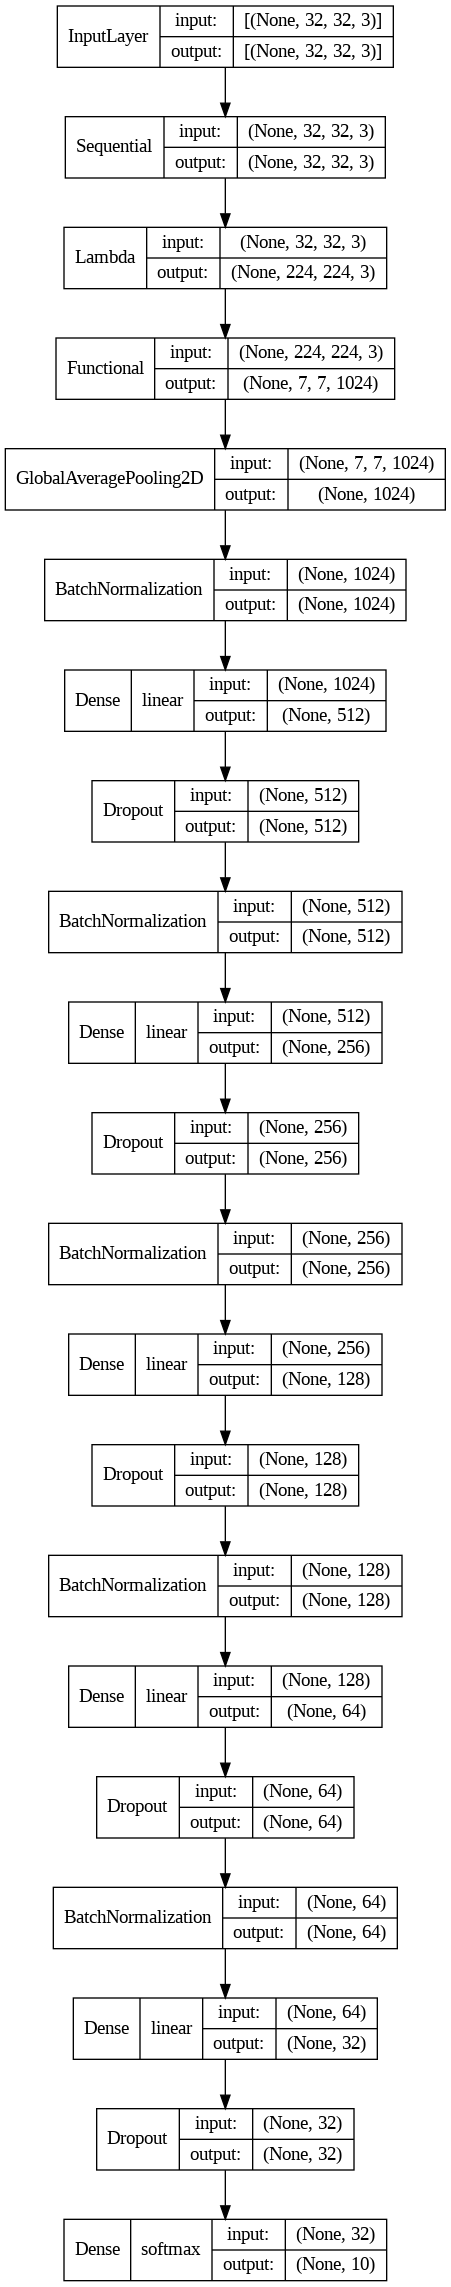

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 512)              

In [9]:
transfer_learning_model = models.Sequential([
  layers.Input(shape=(img_size, img_size, 3)),
  data_augmentation,
  tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (new_img_size, new_img_size))),
  base_model,
  layers.GlobalAveragePooling2D(),
  layers.BatchNormalization(),
  layers.Dense(512),
  layers.Dropout(0.1),
  layers.BatchNormalization(),
  layers.Dense(256),
  layers.Dropout(0.1),
  layers.BatchNormalization(),
  layers.Dense(128),
  layers.Dropout(0.1),
  layers.BatchNormalization(),
  layers.Dense(64),
  layers.Dropout(0.1),
  layers.BatchNormalization(),
  layers.Dense(32),
  layers.Dropout(0.1),
  layers.Dense(n_classes, activation='softmax')
])

plot_model_architecture(transfer_learning_model)

transfer_learning_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
transfer_learning_model.summary()

<details>
  <summary><h3>🔎 <ins>To Go Further<ins/><h3/></summary>

  4. **⭐⭐Train twice**: Modify the training strategy to split it into two consecutive steps :
    1. Train with no fine-tuning (all layers frozen)
    2. Train with fine-tuning (some layers unfrozen)
  This tells the model with parts of its already trained neural architecture are useful when frozen.
  
</details>

### C. Retraining the transfer learning model

It might take a while. (6 min for a GPU or CPU with 256 batch size and cached dataset)

In [10]:
history = transfer_learning_model.fit(ds_train, epochs=2, batch_size=batch_size, validation_data=ds_validation)

Epoch 1/2
196/196 [==============================] - 174s 763ms/step - loss: 0.8862 - accuracy: 0.6961 - val_loss: 0.5573 - val_accuracy: 0.8250
Epoch 2/2
196/196 [==============================] - 133s 677ms/step - loss: 0.6124 - accuracy: 0.7882 - val_loss: 0.4142 - val_accuracy: 0.8770


### D. Evaluating the transfer learning model


In [11]:
test_loss, test_acc = transfer_learning_model.evaluate(ds_test, verbose=2)
print('\nTest accuracy:', test_acc)

36/36 - 25s - loss: 0.4406 - accuracy: 0.8530 - 25s/epoch - 698ms/step

Test accuracy: 0.8529999852180481


## IX. <ins>Saving and deploying the model</ins>


### A. Saving the trained model


There are two ways to save a model.


*   Save only the weights : you have to instantiate its class before using it after loading them
*   Save all the model : you can instantiate it and use it right after loading it

Here we will save all the model.

In [12]:
import uuid

current = uuid.uuid1()
model_name = f'model-{current}.h5'

# Saving the trained model
transfer_learning_model.save(model_name)

*Fun Colab fact
-
You can download the saved model on your computer or upload one using the filesystem provided by Colab (left panel -> 📁).*

### B. Loading the saved model for inference


This code block is used for generating and plotting a confusion matrix for the model's predictions on a validation dataset. A confusion matrix is a table layout that allows visualization of the performance of an algorithm, typically a supervised learning one. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class.

<Axes: >

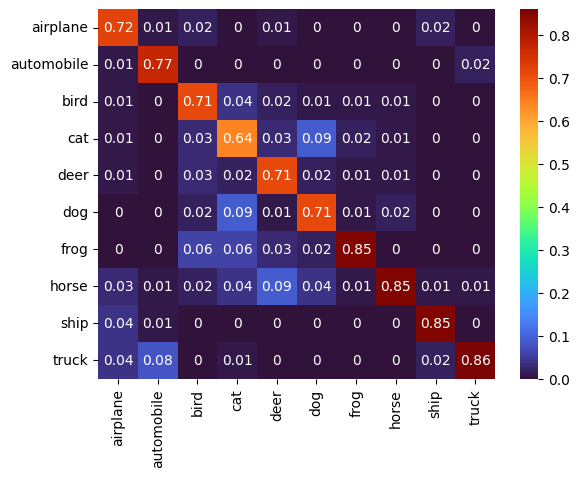

In [16]:
import seaborn as sn
import pandas as pd

# Loading the saved model for inference
loaded_model = models.load_model(model_name)

def get_confusion_matrix(model, validation_generator):
    all_predictions = np.array([])
    all_labels = np.array([])
    for a in validation_generator:
        x_batch, y_batch = a
        predictions = model.predict(x_batch, verbose=0)
        predictions = np.argmax(predictions, axis = 1)
        all_predictions = np.concatenate([all_predictions, predictions])

        all_labels = np.concatenate([all_labels, np.argmax(y_batch, axis=1)])

    return tf.math.confusion_matrix(all_predictions, all_labels)

cf_mx = get_confusion_matrix(loaded_model, ds_test)

df_cm = pd.DataFrame(np.round(cf_mx / 1000, 2), index=[i for i in class_names],
                      columns=[i for i in class_names])
df_cm = df_cm.astype(float)

sn.heatmap(df_cm, annot=True, cmap="turbo")

We can clearly see the category that the model struggles the most with which is the `cat` category. For instance, it wrongly classifies some of cats as dogs, and some of dogs as cats.

Using the "to go further" indications, you can get as high as 92%.
Try it for yourself !

<details>
  <summary><h3>🔎 <ins>To Go Further<ins/><h3/></summary>

  4. **⭐Save & Load previous models**: Instead of loading the last, save & load previous models and check if their confusion matrix changes. Try to guess why.
  
</details>

## X. <ins>Conclusion</ins>

In conclusion, this workshop has provided a comprehensive introduction to using TensorFlow for image classification on the CIFAR-10 dataset. Throughout the workshop, we have covered various essential concepts, techniques, and best practices in building and improving a classification model step by step.

We started by loading and exploring the CIFAR-10 dataset, understanding its structure, and visualizing sample images. Then, we performed data preprocessing, including normalization and data augmentation, to prepare the dataset for training. By incorporating data augmentation techniques such as random rotations, zooms, and flips, we increased the diversity and robustness of the training data.

Next, we built different models, starting from a simple feedforward neural network and progressively enhancing it by adding convolutional layers, dropout, and dense layers. We experimented with various architectural choices, activation functions, and optimizers to improve the model's performance.

Additionally, we explored advanced techniques such as transfer learning, fine-tuning pre-trained models, and utilizing callbacks like ReduceLROnPlateau. These techniques allowed us to leverage the knowledge learned from existing models and adapt it to our specific classification task.

Throughout the workshop, we emphasized the importance of validation datasets, normalization, and regularization techniques to improve model performance and generalization. We also highlighted the significance of monitoring training metrics and evaluating models on unseen test datasets.

By engaging in hands-on coding exercises and suggested experiments, you gained practical experience and a deeper understanding of TensorFlow's capabilities for image classification. You learned to iteratively enhance their models by introducing architectural changes, data preprocessing techniques, and leveraging pre-trained models.

Overall, this workshop has provided you with a solid foundation to continue your journey in TensorFlow and pursue further exploration in deep learning and computer vision applications. Armed with the knowledge and hands-on experience gained from this workshop, you are well-equipped to tackle a wide range of classification tasks and continue to improve your models in real-world scenarios.

I wish you luck for the Kaggle Contest !

Tom

----

Created by Tom Genlis - EPITA 2024 - SCIA - CV

- GitHub : [OrdinaryDev83](https://github.com/OrdinaryDev83)
- Mail : tom.genlis@gmail.com
- Discord : OrdinaryDev83#9338
- LinkedIn : [Tom Genlis](https://www.linkedin.com/in/tom-genlis/)